# 2A - Language model refresher

[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/annabavaresco/ancm2025/blob/main/docs/week_2/2A_Language_Model_Refresher.ipynb)
[![View filled in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/annabavaresco/ancm2025/blob/main/docs/week_2/2A_Language_Model_Refresher.ipynb)

_by Marianne de Heer Kloots, September 2022; based on [ICCN-language tutorial 2021](https://clclab.github.io/ANCM/05_extra_lab_ICCN-EyeTracking.html)_

---

The first part of today's tutorial contains some exercises to refresh your memory about word embeddings and language models. (You might recognize them if you've taken the ICCN course, feel free to skip to the surprisal section if you don't need a refresher.)

These are just exercises to familiarize yourself with language models; you'll find the assignment(s) for your portfolio at the end of the other notebook(s).

In [ ]:
import scipy.io
import torch
from torch.nn import functional as F
import numpy as np
import math
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import cosine, euclidean, pdist, squareform, is_valid_dm, cdist
from collections import defaultdict
from transformers import AutoModel, AutoModelForCausalLM, AutoTokenizer

In [ ]:
#@title Helper functions
def get_vectors(model, tokenizer, texts):
  """
  Return vector embeddings for each text in texts, for each layer of the model.
  """
  text_words = []
  text_vecs = defaultdict(list)

  for text in texts:
    encoded = tokenizer(text, return_tensors="pt")
    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']
    output = model(input_ids=input_ids, attention_mask=attention_mask)
    states = output.hidden_states
    token_len = attention_mask.sum().item()
    decoded = tokenizer.convert_ids_to_tokens(input_ids[0], skip_special_tokens=False)

    if "GPT2" in str(model):
      word_indices = np.array(list(map(lambda e: -1 if e is None else e, encoded.word_ids())))[:token_len]
      word_groups = np.split(np.arange(word_indices.shape[0]), np.unique(word_indices, return_index=True)[1])[1:]
      text_words.append(["".join(list(map(lambda t: t[1:] if t[:1] == "Ġ" else t, np.array(decoded)[g]))) for g in word_groups])
      num_layers = len(model.base_model.h)
      emb_layer = model.wte

    elif "Bert" in str(model):
      word_indices = np.array(list(map(lambda e: -1 if e is None else e, encoded.word_ids())))[1:token_len - 1]
      word_groups = np.split(np.arange(word_indices.shape[0]) + 1, np.unique(word_indices, return_index=True)[1])[1:]
      text_words.append(["".join(list(map(lambda t: t[2:] if t[:2] == "##" else t, np.array(decoded)[g]))) for g in word_groups])

      if "DistilBert" in str(model):
        num_layers = len(model.base_model.transformer.layer)

      else:
        num_layers = len(model.base_model.encoder.layer)
      emb_layer = model.embeddings.word_embeddings

    else:
      return NotImplementedError

    for layer in range(0,num_layers+1):
      text_tokens_output = torch.stack([
          torch.stack([
              # model layer embedding
              states[layer].detach()[:, token_ids_word].mean(axis=1)
              if layer > 0 else
              # input embedding
              emb_layer(input_ids)[:, token_ids_word].mean(axis=1)
              ]).sum(axis=0).squeeze()
              for token_ids_word in word_groups
      ])
      text_vecs[layer].append(text_tokens_output.numpy())

  for layer in range(0,num_layers+1):
    text_vecs[layer] = np.vstack(text_vecs[layer])

  return text_vecs

def compute_distance_matrices(vecs, measure):
  distance_matrices = [
    cdist(vecs[i], vecs[i], measure).round(10)
        for i in range(len(vecs))
  ]
  return distance_matrices

def plot_sentence_RDMs(sentences, distance_matrices, model_name, tokenizer):
  labels = [tokenizer.convert_ids_to_tokens(ids) for ids in tokenizer(sentences)['input_ids']][0][1:-1]

  plot_data = [
      ("xy", 0, "input embeddings"),
      ("x", 1, "layer 1"),
      ("xy", 5, "layer 5"),
      ("x", 11, "layer 11"),
  ]

  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 24))
  fig.suptitle(model_name + ': distance matrices between word embeddings', y=0.9, weight='bold')

  for subplot, (label_axes, matrix_index, title) in zip(itertools.chain.from_iterable(axes), plot_data):
      heatmap_args = dict(
          linewidth=1,
          annot = np.array([[f"{v:.2f}" if (v == 0 or len(str(v)) > 4)
          else f"{v:.1f}" for v in r] for r in distance_matrices[matrix_index]]),
          annot_kws={"size":6.5},
          fmt="",
          cmap = 'magma_r',
          xticklabels=labels,
          yticklabels=labels,
      )

      heatmap = sns.heatmap(distance_matrices[matrix_index], ax=subplot, **heatmap_args)
      subplot.set_title(title)
      for axis in [x for x in "xy" if x not in label_axes]:
          getattr(subplot, f"{axis}axis").set_visible(False)
      subplot.set_yticklabels(labels, rotation=0)
      subplot.set_xticklabels(labels, rotation=90)
  plt.show()

def my_correlation_rsa(DM1, DM2, method='spearman'):
    """
    Compute representational similarity between two distance matrices.
    """
    # selection elements of the upper triangle
    elements1 = DM1[np.triu_indices(DM1.shape[1],k=1)]
    elements2 = DM2[np.triu_indices(DM2.shape[1],k=1)]

    # compute correlation
    if method == 'pearson':
        correlation_of_similarities = stats.pearsonr(elements1, elements2)
    elif method == 'spearman':
        correlation_of_similarities = stats.spearmanr(elements1, elements2)
    else:
        return NotImplementedError

    return correlation_of_similarities

def RSA_matrix(distance_matrices, method='spearman'):
    # create the matrix to fill with the results
    result_matrix = np.ones((len(distance_matrices), len(distance_matrices)))
    for left_ix, right_ix in itertools.combinations(range(len(distance_matrices)), 2):
        left = distance_matrices[left_ix]
        right = distance_matrices[right_ix]
        # compute RS
        correlation, p_value = my_correlation_rsa(left, right, method=method)
        # put the result in the matrix
        result_matrix[left_ix][right_ix] = correlation
        # (optionally) also in the other triangle
        result_matrix[right_ix][left_ix] = correlation
    return result_matrix

def plot_RSA(result_matrix, model_name, dist_method):
    layer_labels = ["input embedding"] + ["layer " + str(l) for l in range(1, len(result_matrix))]
    plt.figure(figsize = (10,6))
    ax = sns.heatmap(result_matrix, annot = True,
                    cmap = 'magma_r',
                    xticklabels=layer_labels,
                    yticklabels=layer_labels )
    ax.set_title(f'RSA: {model_name} embeddings across layers ({dist_method})')
    plt.show()
    plt.close()

## Using pre-trained large language models

**Exercise 1. Word embeddings with pen & paper**

Before running the pretrained language models that we downloaded, let's first consider what word embeddings are and how they can represent useful information about the meaning (and grammatical properties) of words.

Consider the following words: `boy`, `girl`, `man`, `woman`, `king`, `queen`, `prince`, `princess`.

With pen & paper (!), draw a 3 dimensional 'semantic space' that could represent the distinctions between these words. Position each of the words in the space (assuming a word like 'father' is, most of the time 'non-royal').

**Exercise 2. Word embeddings from a large language model**

Now we'll have a look at the learned static input embeddings of a language model. We can visualize the high-dimensional embeddings by running a standard dimensionality reduction technique, PCA, on them and plotting the position of each word in space consisting of the first three principal components.

We will first work with a variant of BERT, a state-of-the-art language model trained for English. BERT was the first widely successful transformer-based language model and remains highly influential. BERT is a so-called 'masked language model'. *Masked language models* are trained to fill in a gap in a sentence, given both prior and future context. For example, the model is given  sentences like "The dog [MASK] loudly", and learns to predict "barked" (or another word) at the masked position — based on both "the dog" and "loudly".

In [ ]:
# load the model and tokenizer
model_name = 'bert-base-uncased'

model = AutoModel.from_pretrained(model_name,
            output_hidden_states=True,
            output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

torch.set_grad_enabled(False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# words to compute embeddings for
words = ["boy", "girl", "man", "woman", "king", "queen", "prince", "princess"]
word_vecs = get_vectors(model, tokenizer, words)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [ ]:
# visualize in 3d space
static_embeddings = pd.DataFrame(np.vstack(word_vecs[0]), index=words)
embeddings = np.vstack(word_vecs[0])
reducer = PCA(n_components=3)
data_pca = reducer.fit_transform(embeddings)
data_pca_df = pd.DataFrame(data_pca, index=words, columns=['PC1', 'PC2', 'PC3'])
fig = px.scatter_3d(data_pca_df, x='PC1', y='PC2', z='PC3', color=data_pca_df.index)
fig.show()

Inspect the PCA vectors and check where the words are positioned in this 3-dimensional space. Is it similar to the space you drew in the pen & paper exercise above?

**Exercise 3. Static versus contextualized embeddings**

In large language models, the input embeddings are static (unique for each word/token). However the activation vectors of higher layers in the model -- which are also the more interesting for downstream tasks and brain prediction -- are not static. Instead, they are _contextualised_, which means that they will be different for every contextualised occurrence of the same word.

We can use tools representational dissimilarity matrices (RDMs) and representational similarity analysis (RSA) to better understand the structure of the embedding spaces. Below we will compute RDMs based on the cosine distances between each word embedding, for embeddings retrieved from the different layers of the large language model.

In [ ]:
sentences = [
    "a computer needs a mouse. a cat eats a mouse."
]
sentence_vecs = get_vectors(model, tokenizer, sentences)

In [ ]:
sentence_RDMs = compute_distance_matrices(sentence_vecs, measure="cosine")
print(len(sentence_RDMs))
print(sentence_RDMs[0].shape)

13
(12, 12)


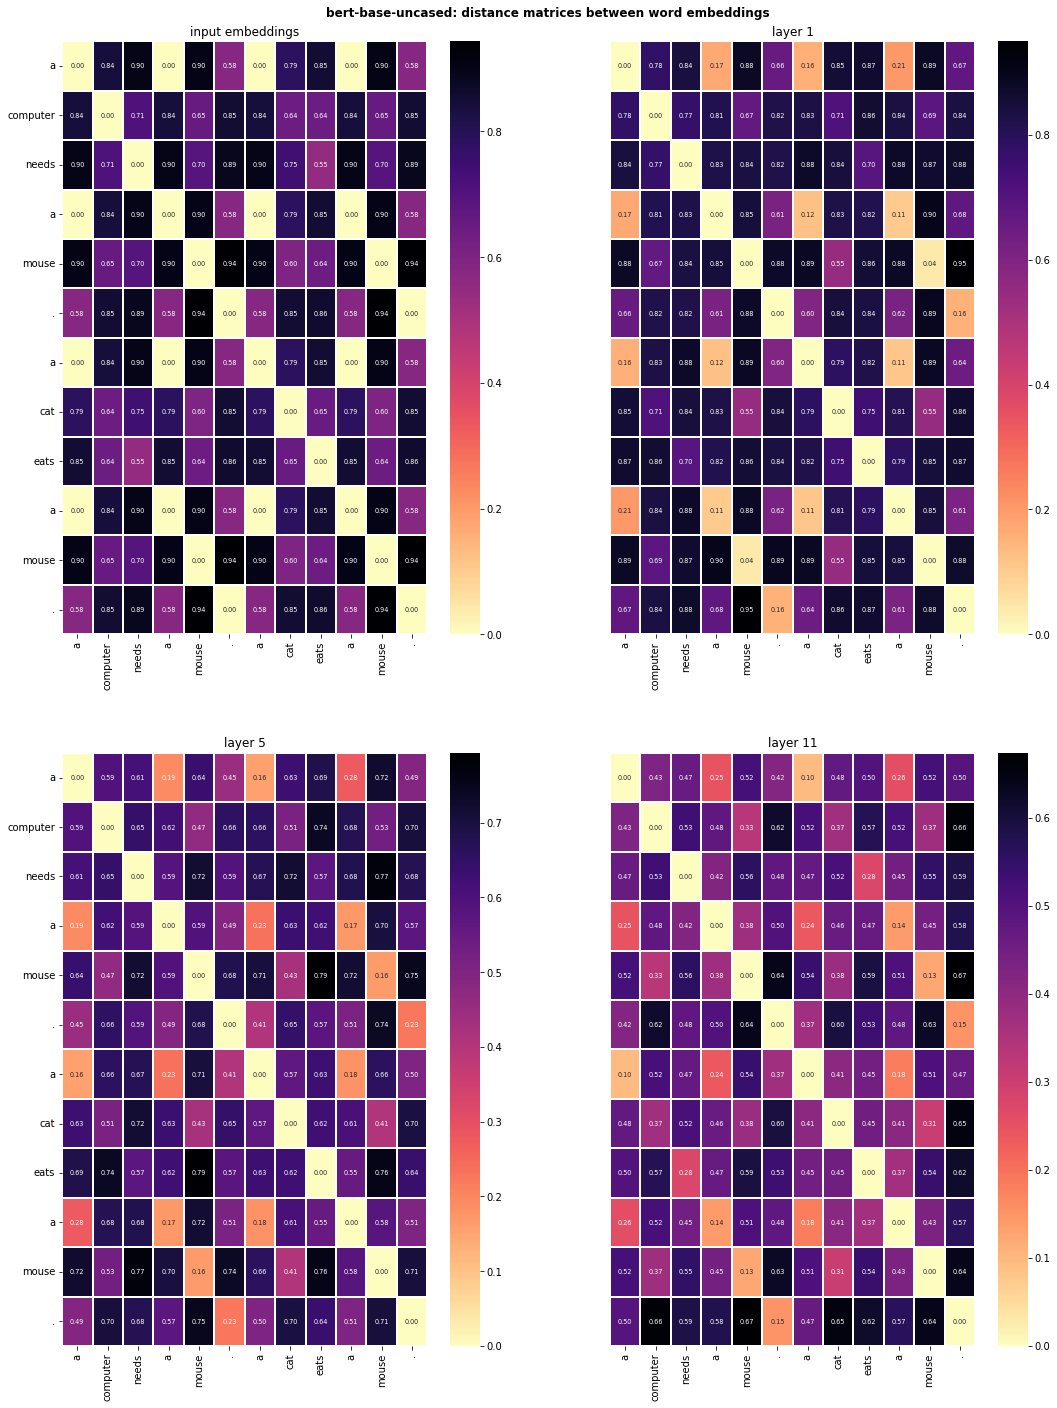

In [ ]:
plot_sentence_RDMs(sentences, sentence_RDMs, model_name, tokenizer)

Using these distance matrices, we can straightforwardly run RSA between layers of the large language model. Below we start with a somewhat larger piece of text, retrieve activation vectors, compute distance matrices using cosine distance and representational similarity using pearson's correlation.

In [ ]:
# input text for the model
text = [
    "Harry had never believed he would meet a boy he hated more than Dudley, but that was before he met Draco Malfoy.",
    "Still, first-year Gryffindors only had Potions with the Slytherins, so they didn't have to put up with Malfoy much.",
    "Or at least, they didn't until they spotted a notice pinned up in the Gryffindor common room that made them all groan."
    ]
text_vecs = get_vectors(model, tokenizer, text)

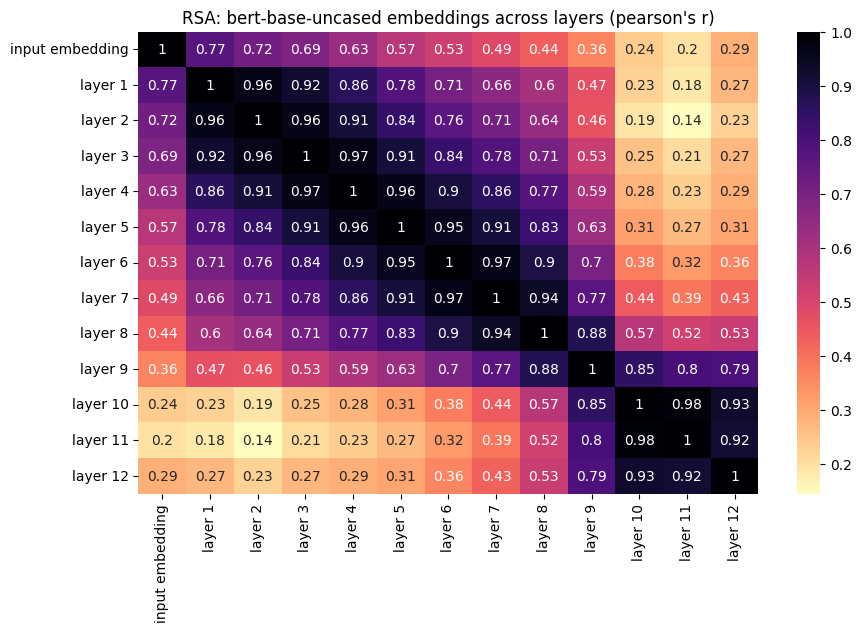

In [ ]:
distance_matrices_cosine = compute_distance_matrices(text_vecs, measure="cosine")
rsa_mat_cosine = RSA_matrix(distance_matrices_cosine, method="pearson")
plot_RSA(rsa_mat_cosine, model_name, dist_method="pearson's r")

**Exercise 4. Surprisal**

Next to examining a large language model's internal representations, we may also want to study its prediction behaviour: what words does the model assign high probabilities to, given some preceding text? How 'surprised' is the model to see a particular word following previous context? For this task we will use a different model: GPT-2.

GPT-2 is an example of an *autoregressive* (or: 'causal') language model. Compared to masked language models, autoregressive language models are trained on the more traditional language modelling task of predicting words based on only preceding context (without seeing the future). When we use language models in analysing measurements of human language processing, it's important to consider what information a model makes use of when predicting words, and whether it aligns with what was available to participants in the experiment.

In [ ]:
# load the model and tokenizer
model_name = 'gpt2'

model = AutoModelForCausalLM.from_pretrained(model_name,
            output_hidden_states=True,
            output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

torch.set_grad_enabled(False)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

We can use the model output logits (softmaxing them into probabilities) to find the words most likely to follow our given context according to the model.

In [ ]:
context = "They returned the book to the"
ctx_input_ids = tokenizer.encode(context, return_tensors="pt")
output = model(ctx_input_ids)
print(output.logits.shape)

torch.Size([1, 6, 50257])


In [ ]:
# logits of last hidden state
next_token_logits = output.logits[:, -1, :]
# taking the softmax gives us the probability
next_token_probs = F.softmax(next_token_logits, dim=-1)

In [ ]:
def top_n_next_tokens(vocab_probs, tokenizer, top_n):
  # top N most likely token ids
  next_token_ids = np.argsort(vocab_probs)[0][-top_n:]
  # find the tokens for these ids
  next_tokens = tokenizer.decode(next_token_ids).split(' ')[1:]
  # find the probabilities
  next_token_probs = list(vocab_probs[:, next_token_ids][0].numpy())
  # sort the tokens and their probabilities in descending order
  desc_token_probs = list(zip(next_tokens, next_token_probs))[::-1]
  return desc_token_probs

In [ ]:
top_n_next_tokens(next_token_probs, tokenizer, top_n=5)

[('library', 0.028046276),
 ('police', 0.014596471),
 ('publisher', 0.012090932),
 ('family', 0.01117981),
 ('owner', 0.01078586)]

In [ ]:
def word_prob(target_word, vocab_probs, tokenizer):
  # get the input id for the target word (add a space before)
  tw_input_ids = tokenizer.encode(' ' + target_word)
  # if the tokenizer splits this word into multiple ids,
  # then the word is not in the vocabulary
  if len(tw_input_ids) != 1:
    raise ValueError("This word is not in the model's vocabulary")
  else:
    tw_input_id = tw_input_ids[0]
  # probability as numpy float
  tw_prob = next_token_probs[:, tw_input_id][0].numpy()
  return tw_prob

In [ ]:
target_word = 'library'
target_word_prob = word_prob(target_word, next_token_probs, tokenizer)
target_word_prob

array(0.02804628, dtype=float32)

When language model predictions are applied to model predictability effects in human language comprehension, predictability is usually operationalized as *surprisal* rather than raw probability: the higher the surprisal value, the more 'surprised' a model is to encounter a particular word following a sequence. Try out a few different target words, and see how the surprisal changes!

In [ ]:
def surprisal(prob):
  return -math.log(prob)

In [ ]:
surprisal(target_word_prob)

3.573895020495925